In [1]:
import pandas as pd

df = pd.read_csv('raw_training_df.csv')
df = df.iloc[:,1:].T

metadata = pd.read_csv('metadata.csv')
metadata = metadata.set_index('sample_id')

In [2]:
bio_tag = 'cell_type'
batch_tag = 'prep_method_broad'

In [3]:
import scanpy as sc

adata = sc.AnnData(df)
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True, how='left')

/home/chzhan1/.local/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
import torch
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
torch.cuda.device_count()

0

In [12]:
import scvi

scvi.model.SCVI.setup_anndata(adata, batch_key=batch_tag)
model = scvi.model.SCVI(
    adata,
    n_hidden = 64, n_layers=6, n_latent=3, gene_likelihood="zinb"
    dropout_rate = 0.1, latent_distribution = 'norm', dispersion = 'gene-cell'
)

model.train(plan_kwargs= {'lr': 0.0.0078038006594481875}, accelerator = device)

MisconfigurationException: No supported gpu backend found!

In [7]:
scvi_matrix = model.get_latent_representation()


#scvi_matrix_full = model.get_normalized_expression()

scvi_matrix = pd.DataFrame(scvi_matrix)
scvi_matrix['sample_id'] = df.index
scvi_matrix = scvi_matrix.set_index('sample_id', drop = True)

scvi_matrix.columns = scvi_matrix.columns = ['V' + str(col) for col in scvi_matrix.columns]

adata.obsm["X_3_latent"] = scvi_matrix.values

In [8]:
# Merge DataFrames by 'sample_id'
scvi_representation_coordinates_merged = pd.merge(scvi_matrix, metadata, on='sample_id')

# Replace NaN with 'NA'
scvi_representation_coordinates_merged.fillna('NA', inplace=True)

In [9]:
scvi_representation_coordinates_merged

,V0,V1,V2,dataset_id,cell_type,parental_cell_type,final_cell_type,disease_state,organism,sample_type,...,prep_method_broad,preparation_method,capture,fragmentation,stranded,sequencing_layout,average_read_length,sequencer,training_atlas,sample_id_without_datasetid
sample_id,,,,,,,,,,,,,,,,,,,,,
1611_GSM2027310,-4.541587,3.507635,6.212718,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC2,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027310
1611_GSM2027311,-4.529855,3.360756,6.702286,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC1,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027311
1611_GSM2027312,-3.005116,0.504935,2.683710,1611,plasmacytoid dendritic cell,NA,NA,normal,homo sapiens,pDC,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027312
1611_GSM2027313,-3.741321,2.174157,3.966259,1611,plasmacytoid dendritic cell,NA,NA,normal,homo sapiens,pDC,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,50,Illumina HiSeq 2000,include,GSM2027313
1611_GSM2027314,-4.489219,3.505786,6.058342,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC2,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9798_Kolf2_iMacs_UT_16h_2_01,2.359684,3.678094,-0.782815,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_16h_3_01,2.288674,3.790161,-0.845531,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_6h_1_01,2.102047,3.035480,-0.995089,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_6h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2


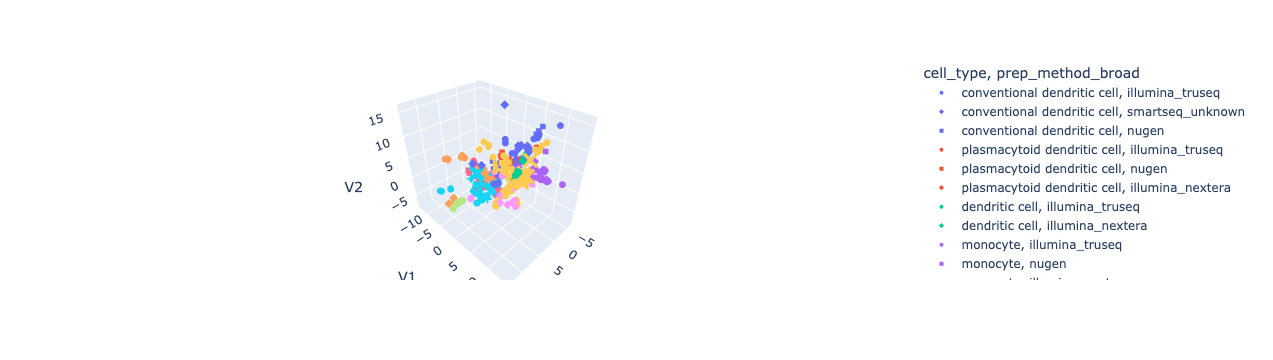

In [11]:
import plotly.express as px

# Plotting
fig = px.scatter_3d(
    scvi_representation_coordinates_merged,
    x='V0',
    y='V1',
    z='V2',
    color= bio_tag,
    symbol = batch_tag
)

# Adjusting marker size
fig.update_traces(marker=dict(size=4))

# Show the plot
fig.show()